In [236]:
# Cell 0: configuration + imports
from pathlib import Path
import os
import sys
import json
import warnings
from pprint import pprint

# Data / ML imports
import numpy as np
import pandas as pd
import joblib
# sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    r2_score, mean_absolute_error, mean_squared_error
)

# xgboost
from xgboost import XGBClassifier, XGBRegressor

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Optuna (uncomment to use)
# import optuna

# Notebook-friendly settings
sns.set_theme(style="whitegrid", font_scale=1.05)
plt.rcParams["figure.dpi"] = 200
warnings.filterwarnings("ignore")

# Output folder
OUTDIR = Path("./outputs")
OUTDIR.mkdir(parents=True, exist_ok=True)

print("Environment ready. Output directory:", OUTDIR.resolve())


Environment ready. Output directory: /content/outputs


In [237]:
import os
import pandas as pd

# Path to the dataset folder
path = "/kaggle/input/chemotherapy-regimens-based-on-patient-data"

# List files to confirm
print("Files in dataset folder:", os.listdir(path))

# Load the correct CSV file
csv_file = os.path.join(path, "chemotherapy_patient_data.csv")
df = pd.read_csv(csv_file)

# View the first few rows
# print(df.head())
# Cell 1: load_and_preprocess_data()
def load_and_preprocess_data(candidate_paths=None, verbose=True):
    """
    Preprocess patient dataset for modeling.

    Returns:
        df_clean: preprocessed dataframe
        regimen_encoder: fitted LabelEncoder for chemo_regimen
        numerical_features: list of numerical feature names
        categorical_features: list of categorical feature names
    """

    df_clean = df.copy()

    # -----------------------
    # 1. Type conversions
    # -----------------------
    df_clean[numerical_features] = df_clean[numerical_features].apply(pd.to_numeric, errors='coerce')
    df_clean[categorical_features] = df_clean[categorical_features].astype(str)

    # -----------------------
    # 2. Missing value imputation
    # -----------------------
    # Numerical: median
    num_imputer = SimpleImputer(strategy='median')
    df_clean[numerical_features] = num_imputer.fit_transform(df_clean[numerical_features])
    df_clean = df_clean.dropna(subset=[chemo_regimen_target])
    # Categorical: 'Unknown'
    cat_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
    df_clean[categorical_features] = cat_imputer.fit_transform(df_clean[categorical_features])

    # -----------------------
    # 3. Label encode chemo_regimen (classification target)
    # -----------------------
    regimen_encoder = LabelEncoder()
    df_clean['regimen_encoded'] = regimen_encoder.fit_transform(df_clean[chemo_regimen_target])

    # -----------------------
    # 4. Ensure regression targets are numeric
    # -----------------------
    for target in [dosage_target, cycles_target, survival_target]:
        df_clean[target] = pd.to_numeric(df_clean[target], errors='coerce')
        df_clean[target].fillna(df_clean[target].median(), inplace=True)

    return df_clean, regimen_encoder

# Usage example (will be run in main)
# df = load_and_preprocess_data()

Files in dataset folder: ['chemotherapy_patient_data.csv', 'README.md']


In [238]:
# Cell 2: feature + target names (edit if your CSV uses different col names)
patient_features = ['Age', 'Sex', 'BMI', 'Smoking_Status', 'Cancer_Type',
                    'Genetic_Mutation', 'Tumor_Stage', 'Tumor_Size', 'Metastasis_Status']

chemo_regimen_target = 'Chemotherapy_Regimen'
dosage_target = 'Dosage (mg/m²)'    # if your CSV uses slightly different string, replace here
cycles_target = 'Cycles_Completed'
survival_target = 'Overall_Survival_Months'

# categorical & numerical lists (derived from patient_features)
categorical_features = ['Sex', 'Smoking_Status', 'Cancer_Type',
                        'Genetic_Mutation', 'Tumor_Stage', 'Metastasis_Status']
numerical_features = ['Age', 'BMI', 'Tumor_Size']

print("Configured features and targets. Edit this cell if column names differ in your CSV.")


Configured features and targets. Edit this cell if column names differ in your CSV.


In [239]:
#Research Objectives ------------->

#Integrative Prediction of Chemotherapy Regimens and Overall Survival in Cancer Patients Using XGBoost and Cox Regression


#1. Based on the patient’s profile (age, sex, BMI, smoking status, cancer type, genetic mutation, tumor stage/size, metastasis), predict which chemotherapy regimen/dosage (in range)/cycles completed is recommended using both XGBOOST.
#2. Rank the predictions based on some metric.

#WORK
# Find more suitable models
# Encode Overall Survival Months.

In [240]:
# Cell 3: Expert train_models with robust preprocessing & SMOTE for classifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from xgboost import XGBClassifier, XGBRegressor
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np

def train_models(data, random_state=42, verbose=True):
    """
    Trains four models:
      - regimen_model (XGBClassifier with SMOTE)
      - dosage_model (XGBRegressor)
      - cycles_model (XGBRegressor)
      - survival_model (XGBRegressor)
    Returns trained pipelines + LabelEncoder + train/test splits.
    """
    if data is None:
        raise ValueError("data is None. Load dataset first.")

    df = data.copy()

    # ----------------------
    # Basic checks & missing values
    # ----------------------
    required_cols = patient_features + [chemo_regimen_target, dosage_target, cycles_target, survival_target]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' missing in dataset.")

    # Convert numeric, fill missing with median
    df[numerical_features] = df[numerical_features].apply(pd.to_numeric, errors='coerce')
    df[numerical_features] = df[numerical_features].fillna(df[numerical_features].median())
    # Fill categorical missing
    df[categorical_features] = df[categorical_features].astype(str).fillna("Unknown")

    # ----------------------
    # Encode regimen
    # ----------------------
    regimen_encoder = LabelEncoder()
    df['regimen_encoded'] = regimen_encoder.fit_transform(df[chemo_regimen_target])

    # ----------------------
    # Preprocessors
    # ----------------------
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    base_preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

    # Dosage/cycles include regimen as categorical
    dosage_cat_list = categorical_features + [chemo_regimen_target]
    dosage_preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), dosage_cat_list)
    ])

    # Survival includes dosage & cycles
    survival_num_list = numerical_features + [dosage_target, cycles_target]
    survival_cat_list = categorical_features + [chemo_regimen_target]
    survival_preprocessor = ColumnTransformer([
        ('num', numeric_transformer, survival_num_list),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), survival_cat_list)
    ])

    # ----------------------
    # Train/Test splits
    # ----------------------
    # Regimen classifier (use stratify)
    X_cls = df[patient_features]
    y_cls = df['regimen_encoded']
    Xc_train, Xc_test, yc_train, yc_test = train_test_split(
        X_cls, y_cls, test_size=0.2, stratify=y_cls, random_state=random_state
    )

    # Dosage regressor
    X_dos = df[patient_features + [chemo_regimen_target]]
    y_dos = df[dosage_target]
    Xd_train, Xd_test, yd_train, yd_test = train_test_split(X_dos, y_dos, test_size=0.2, random_state=random_state)

    # Cycles regressor
    X_cyc = df[patient_features + [chemo_regimen_target]]
    y_cyc = df[cycles_target]
    Xcy_train, Xcy_test, ycy_train, ycy_test = train_test_split(X_cyc, y_cyc, test_size=0.2, random_state=random_state)

    # Survival regressor
    X_surv = df[patient_features + [chemo_regimen_target, dosage_target, cycles_target]]
    y_surv = df[survival_target]
    Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_surv, y_surv, test_size=0.2, random_state=random_state)

    # ----------------------
    # XGBoost common params
    # ----------------------
    common_xgb_kwargs = dict(
        n_estimators=1000,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="hist",
        random_state=random_state,
        verbosity=0
    )

    # ----------------------
    # Regimen classifier w/ SMOTE
    # ----------------------
    smote = SMOTE(random_state=random_state)
    Xc_train_pre = base_preprocessor.fit_transform(Xc_train)
    Xc_test_pre = base_preprocessor.transform(Xc_test)
    Xc_train_res, yc_train_res = smote.fit_resample(Xc_train_pre, yc_train)

    clf = XGBClassifier(
        use_label_encoder=False,
        objective='multi:softprob',
        eval_metric='mlogloss',
        **common_xgb_kwargs
    )
    clf.fit(Xc_train_res, yc_train_res)

    regimen_model = Pipeline([('preproc', base_preprocessor), ('clf', clf)])

    # ----------------------
    # Dosage model
    # ----------------------
    dosage_model = Pipeline([
        ('preproc', dosage_preprocessor),
        ('reg', XGBRegressor(objective='reg:squarederror', **common_xgb_kwargs))
    ])
    Xd_train_pre = dosage_preprocessor.fit_transform(Xd_train)
    Xd_test_pre = dosage_preprocessor.transform(Xd_test)
    dosage_model.named_steps['reg'].fit(Xd_train_pre, yd_train)

    # ----------------------
    # Cycles model
    # ----------------------
    cycles_model = Pipeline([
        ('preproc', dosage_preprocessor),
        ('reg', XGBRegressor(objective='reg:squarederror', **common_xgb_kwargs))
    ])
    Xcy_train_pre = dosage_preprocessor.fit_transform(Xcy_train)
    Xcy_test_pre = dosage_preprocessor.transform(Xcy_test)
    cycles_model.named_steps['reg'].fit(Xcy_train_pre, ycy_train)

    # ----------------------
    # Survival model
    # ----------------------
    survival_model = Pipeline([
        ('preproc', survival_preprocessor),
        ('reg', XGBRegressor(objective='reg:squarederror', **common_xgb_kwargs))
    ])
    Xs_train_pre = survival_preprocessor.fit_transform(Xs_train)
    Xs_test_pre = survival_preprocessor.transform(Xs_test)
    survival_model.named_steps['reg'].fit(Xs_train_pre, ys_train)

    # ----------------------
    # Save splits
    # ----------------------
    splits = dict(
        regimen=(Xc_train, Xc_test, yc_train, yc_test),
        dosage=(Xd_train, Xd_test, yd_train, yd_test),
        cycles=(Xcy_train, Xcy_test, ycy_train, ycy_test),
        survival=(Xs_train, Xs_test, ys_train, ys_test)
    )

    if verbose:
        print("Models trained successfully!")

    return {
        'regimen_model': regimen_model,
        'dosage_model': dosage_model,
        'cycles_model': cycles_model,
        'survival_model': survival_model,
        'regimen_encoder': regimen_encoder,
        'splits': splits
    }


In [241]:
# Cell 4: evaluate_models() - robust evaluation + plots saved to OUTDIR
def evaluate_models(models_dict, print_reports=True):
    """
    models_dict: dict returned by train_models()
    Produces evaluation metrics + saves plots to OUTDIR
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import (
        classification_report, accuracy_score, f1_score, confusion_matrix,
        mean_absolute_error, r2_score
    )

    regimen_model = models_dict['regimen_model']
    dosage_model = models_dict['dosage_model']
    cycles_model = models_dict['cycles_model']
    survival_model = models_dict['survival_model']
    regimen_encoder = models_dict['regimen_encoder']
    splits = models_dict['splits']

    # Utility plotting helper
    def save_fig(fig, fname, show=True):
        path = OUTDIR / fname
        fig.savefig(path, dpi=300, bbox_inches='tight')
        if show:
            plt.show()
        plt.close(fig)
        print("Saved:", path)

    # ---------- Regimen classifier ----------
    Xtr, Xte, ytr, yte = splits['regimen']

    # Use full pipeline for prediction (includes preprocessing)
    ytr_pred = regimen_model.predict(Xtr)
    yte_pred = regimen_model.predict(Xte)

    acc_tr = accuracy_score(ytr, ytr_pred)
    acc_te = accuracy_score(yte, yte_pred)
    f1_te = f1_score(yte, yte_pred, average='macro')

    if print_reports:
        print("Regimen classifier: Train Acc={:.3f}, Test Acc={:.3f}, Test F1-macro={:.3f}".format(acc_tr, acc_te, f1_te))
        print("Classification report (test):")
        # Convert target_names to string to avoid TypeError
        target_names = regimen_encoder.classes_.astype(str)
        print(classification_report(yte, yte_pred, target_names=target_names))

    # Confusion matrix plot
    cm = confusion_matrix(yte, yte_pred)
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
                xticklabels=target_names, yticklabels=target_names)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title("Confusion Matrix (regimen)")
    save_fig(fig, "confusion_matrix_regimen.png")

    # ---------- Dosage regressor ----------
    Xtr, Xte, ytr, yte = splits['dosage']
    ytr_pred = dosage_model.predict(Xtr)
    yte_pred = dosage_model.predict(Xte)

    r2_tr = r2_score(ytr, ytr_pred)
    r2_te = r2_score(yte, yte_pred)
    mae_te = mean_absolute_error(yte, yte_pred)

    print("\nDosage regressor: Train R2={:.3f}, Test R2={:.3f}, Test MAE={:.3f}".format(r2_tr, r2_te, mae_te))

    fig, ax = plt.subplots(figsize=(6,5))
    ax.scatter(yte, yte_pred, alpha=0.6)
    ax.plot([yte.min(), yte.max()], [yte.min(), yte.max()], 'r--')
    ax.set_xlabel("True Dosage"); ax.set_ylabel("Predicted Dosage"); ax.set_title("Dosage: Pred vs True")
    save_fig(fig, "dosage_pred_vs_true.png")

    fig = plt.figure(figsize=(6,4))
    sns.histplot(yte - yte_pred, bins=30, kde=True)
    plt.title("Dosage residuals (true - pred)")
    save_fig(fig, "dosage_residuals.png")

    # ---------- Cycles regressor ----------
    Xtr, Xte, ytr, yte = splits['cycles']
    ytr_pred = cycles_model.predict(Xtr)
    yte_pred = cycles_model.predict(Xte)

    print("\nCycles regressor: Train R2={:.3f}, Test R2={:.3f}, Test MAE={:.3f}".format(
        r2_score(ytr, ytr_pred), r2_score(yte, yte_pred), mean_absolute_error(yte, yte_pred)
    ))

    fig, ax = plt.subplots(figsize=(6,5))
    ax.scatter(yte, yte_pred, alpha=0.6)
    ax.plot([yte.min(), yte.max()], [yte.min(), yte.max()], 'r--')
    ax.set_xlabel("True Cycles"); ax.set_ylabel("Predicted Cycles"); ax.set_title("Cycles: Pred vs True")
    save_fig(fig, "cycles_pred_vs_true.png")

    fig = plt.figure(figsize=(6,4))
    sns.histplot(yte - yte_pred, bins=30, kde=True)
    plt.title("Cycles residuals (true - pred)")
    save_fig(fig, "cycles_residuals.png")

    # ---------- Survival regressor ----------
    Xtr, Xte, ytr, yte = splits['survival']
    ytr_pred = survival_model.predict(Xtr)
    yte_pred = survival_model.predict(Xte)

    print("\nSurvival regressor: Train R2={:.3f}, Test R2={:.3f}, Test MAE={:.3f}".format(
        r2_score(ytr, ytr_pred), r2_score(yte, yte_pred), mean_absolute_error(yte, yte_pred)
    ))

    fig, ax = plt.subplots(figsize=(6,5))
    ax.scatter(yte, yte_pred, alpha=0.6)
    ax.plot([yte.min(), yte.max()], [yte.min(), yte.max()], 'r--')
    ax.set_xlabel("True Survival"); ax.set_ylabel("Predicted Survival"); ax.set_title("Survival: Pred vs True")
    save_fig(fig, "survival_pred_vs_true.png")

    fig = plt.figure(figsize=(6,4))
    sns.histplot(yte - yte_pred, bins=30, kde=True)
    plt.title("Survival residuals (true - pred)")
    save_fig(fig, "survival_residuals.png")



Statistic Visualizations


In [242]:
# Cell 5: supplemental viz - dataset & feature importances
def visualize_dataset(df, show=True):
    # Age distribution
    fig, ax = plt.subplots(figsize=(6,4))
    sns.histplot(df['Age'].dropna(), bins=30, kde=True, ax=ax)
    ax.set_title("Age distribution")
    ax.set_xlabel("Age")
    path = OUTDIR/"age_distribution.png"
    fig.savefig(path, dpi=300, bbox_inches='tight')
    if show: plt.show()
    plt.close(fig)
    print("Saved:", path)

    # Regimen counts
    fig, ax = plt.subplots(figsize=(7,5))
    top_order = df[chemo_regimen_target].value_counts().index
    sns.countplot(y=chemo_regimen_target, data=df, order=top_order, ax=ax)
    ax.set_title("Chemotherapy regimen counts")
    path = OUTDIR/"regimen_counts.png"
    fig.savefig(path, dpi=300, bbox_inches='tight')
    if show: plt.show()
    plt.close(fig)
    print("Saved:", path)

    # Survival histogram
    fig, ax = plt.subplots(figsize=(6,4))
    sns.histplot(df[survival_target].dropna(), bins=30, kde=True, ax=ax, color="darkred")
    ax.set_title("Overall survival (months)")
    path = OUTDIR/"survival_distribution.png"
    fig.savefig(path, dpi=300, bbox_inches='tight')
    if show: plt.show()
    plt.close(fig)
    print("Saved:", path)


def get_feature_names_from_preprocessor(preprocessor):
    """
    Attempt to recover transformed feature names from ColumnTransformer with OneHotEncoder.
    Works for scikit-learn >= 1.0 which supports get_feature_names_out.
    """
    try:
        names = []
        transformers = preprocessor.transformers_
        for name, trans, cols in transformers:
            if name == "remainder":
                continue
            if hasattr(trans, "get_feature_names_out"):
                # pipeline handling
                try:
                    feat_names = trans.get_feature_names_out(cols)
                except Exception:
                    # if trans is pipeline
                    if hasattr(trans, 'named_steps'):
                        last = trans.named_steps[list(trans.named_steps.keys())[-1]]
                        feat_names = last.get_feature_names_out(cols)
                    else:
                        feat_names = cols
                if isinstance(feat_names, (list, np.ndarray)):
                    names.extend([str(x) for x in feat_names])
                else:
                    names.append(str(feat_names))
            else:
                # fallback - just append input column names
                if isinstance(cols, (list, tuple, np.ndarray)):
                    names.extend([str(c) for c in cols])
                else:
                    names.append(str(cols))
        return names
    except Exception as e:
        print("Could not extract names from preprocessor:", e)
        return None


def plot_feature_importances(model_pipeline, model_label="model", topk=20, show=True):
    """
    model_pipeline: pipeline with named_steps['reg'] or ['clf'] that is XGBoost estimator.
    """
    # pick estimator
    est = None
    if 'clf' in model_pipeline.named_steps:
        est = model_pipeline.named_steps['clf']
    elif 'reg' in model_pipeline.named_steps:
        est = model_pipeline.named_steps['reg']
    elif 'regressor' in model_pipeline.named_steps:
        est = model_pipeline.named_steps['regressor']
    elif 'classifier' in model_pipeline.named_steps:
        est = model_pipeline.named_steps['classifier']
    else:
        # fallback to second step
        est = list(model_pipeline.named_steps.values())[-1]

    if not hasattr(est, "feature_importances_"):
        print("Estimator doesn't have feature_importances_. Skipping.")
        return

    importances = est.feature_importances_
    # get feature names from preprocessor if possible
    pre = model_pipeline.named_steps[list(model_pipeline.named_steps.keys())[0]]
    feature_names = get_feature_names_from_preprocessor(pre)
    if feature_names is None or len(feature_names) != len(importances):
        feature_names = [f"f{i}" for i in range(len(importances))]

    imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    imp_df = imp_df.sort_values('importance', ascending=False).head(topk)
    fig, ax = plt.subplots(figsize=(7, max(4, 0.25*len(imp_df))))
    sns.barplot(x='importance', y='feature', data=imp_df, ax=ax)
    ax.set_title(f"Top {topk} features - {model_label}")
    path = OUTDIR/f"feature_importance_{model_label}.png"
    fig.savefig(path, dpi=300, bbox_inches='tight')
    if show: plt.show()
    plt.close(fig)
    print("Saved:", path)


In [243]:
# Cell 6: saving / loading models
def save_models(models_dict, outdir=OUTDIR):
    outdir = Path(outdir)
    outdir.mkdir(parents=True, exist_ok=True)
    joblib.dump(models_dict['regimen_model'], outdir/"regimen_model.joblib")
    joblib.dump(models_dict['dosage_model'], outdir/"dosage_model.joblib")
    joblib.dump(models_dict['cycles_model'], outdir/"cycles_model.joblib")
    joblib.dump(models_dict['survival_model'], outdir/"survival_model.joblib")
    joblib.dump(models_dict['regimen_encoder'], outdir/"regimen_encoder.joblib")
    # optional: save splits
    joblib.dump(models_dict['splits'], outdir/"train_test_splits.joblib")
    print("Saved models to", outdir.resolve())

def load_models(outdir=OUTDIR):
    outdir = Path(outdir)
    models = {}
    models['regimen_model'] = joblib.load(outdir/"regimen_model.joblib")
    models['dosage_model'] = joblib.load(outdir/"dosage_model.joblib")
    models['cycles_model'] = joblib.load(outdir/"cycles_model.joblib")
    models['survival_model'] = joblib.load(outdir/"survival_model.joblib")
    models['regimen_encoder'] = joblib.load(outdir/"regimen_encoder.joblib")
    models['splits'] = joblib.load(outdir/"train_test_splits.joblib")
    print("Loaded models from", outdir.resolve())
    return models


In [244]:
# Cell 7: predict_and_rank_regimens
def predict_and_rank_regimens(patient_profile: dict, models_dict, top_n=5, candidate_regimens=None):
    """
    patient_profile: dict containing patient_features keys.
    models_dict: dict returned by train_models() or load_models()
    Returns list of top_n regimen dicts with predicted dosage, cycles, survival.
    """
    regimen_model = models_dict['regimen_model']
    dosage_model = models_dict['dosage_model']
    cycles_model = models_dict['cycles_model']
    survival_model = models_dict['survival_model']
    regimen_encoder = models_dict['regimen_encoder']

    # Candidate regimens: if not provided, use encoder classes
    if candidate_regimens is None:
        candidate_regimens = list(regimen_encoder.classes_)

    patient_df = pd.DataFrame([patient_profile])
    # Ensure expected columns present (fill missing with default)
    for col in patient_features:
        if col not in patient_df.columns:
            patient_df[col] = np.nan
    patient_df[numerical_features] = patient_df[numerical_features].apply(pd.to_numeric, errors='coerce')
    patient_df[categorical_features] = patient_df[categorical_features].fillna("Unknown")

    predictions = []
    for regimen in candidate_regimens:
        temp = patient_df.copy()
        temp[chemo_regimen_target] = regimen

        # Predict dosage & cycles
        try:
            pred_dose = float(dosage_model.predict(temp[patient_features + [chemo_regimen_target]])[0])
        except Exception as e:
            pred_dose = np.nan
        try:
            pred_cycles = float(cycles_model.predict(temp[patient_features + [chemo_regimen_target]])[0])
        except Exception as e:
            pred_cycles = np.nan

        # Prepare survival input
        surv_input = temp.copy()
        surv_input[dosage_target] = pred_dose
        surv_input[cycles_target] = pred_cycles
        try:
            pred_surv = float(survival_model.predict(surv_input[patient_features + [chemo_regimen_target, dosage_target, cycles_target]])[0])
        except Exception as e:
            pred_surv = np.nan

        predictions.append({
            'Regimen': regimen,
            'Predicted_Dosage': round(pred_dose, 2) if not np.isnan(pred_dose) else None,
            'Predicted_Cycles': int(np.round(pred_cycles)) if not np.isnan(pred_cycles) else None,
            'Predicted_Survival_Months': round(pred_surv, 2) if not np.isnan(pred_surv) else None
        })

    ranked = sorted([p for p in predictions if p['Predicted_Survival_Months'] is not None],
                    key=lambda x: x['Predicted_Survival_Months'], reverse=True)
    return ranked[:top_n]



--- Training models (this may take some minutes) ---
Models trained successfully!
Saved models to /content/outputs
Regimen classifier: Train Acc=0.628, Test Acc=0.266, Test F1-macro=0.242
Classification report (test):
              precision    recall  f1-score   support

        ABVD       0.26      0.25      0.25      2610
        CHOP       0.21      0.16      0.18      2128
      FOLFOX       0.31      0.43      0.36      3140
 Gemcitabine       0.20      0.15      0.17      2075

    accuracy                           0.27      9953
   macro avg       0.25      0.25      0.24      9953
weighted avg       0.25      0.27      0.26      9953



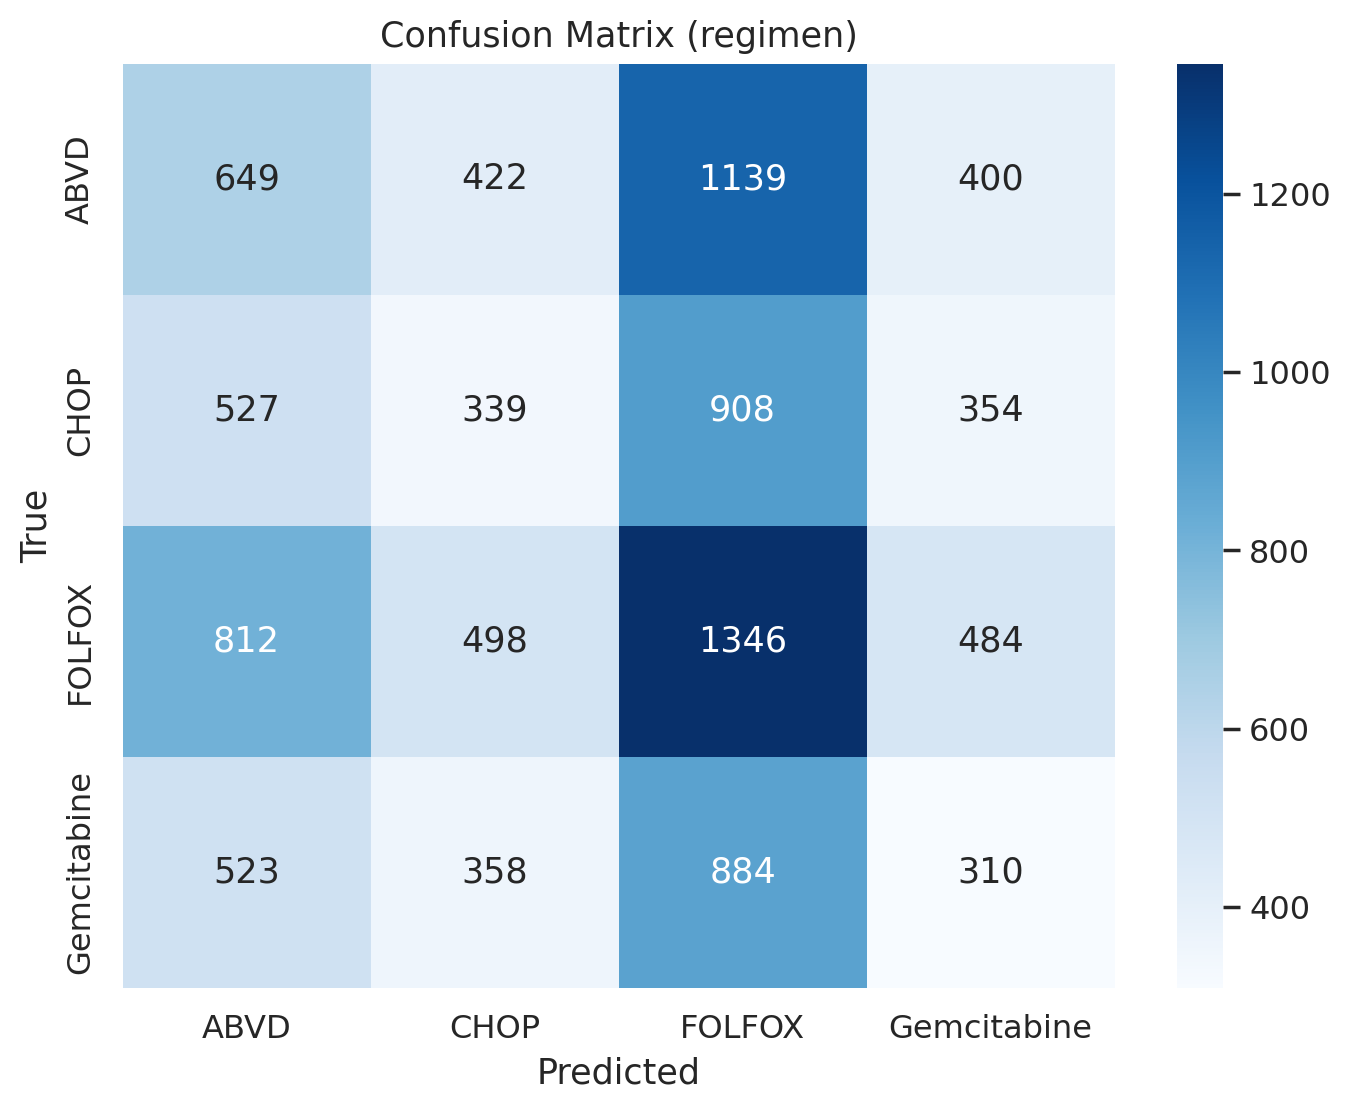

Saved: outputs/confusion_matrix_regimen.png

Dosage regressor: Train R2=0.327, Test R2=-0.043, Test MAE=138.074


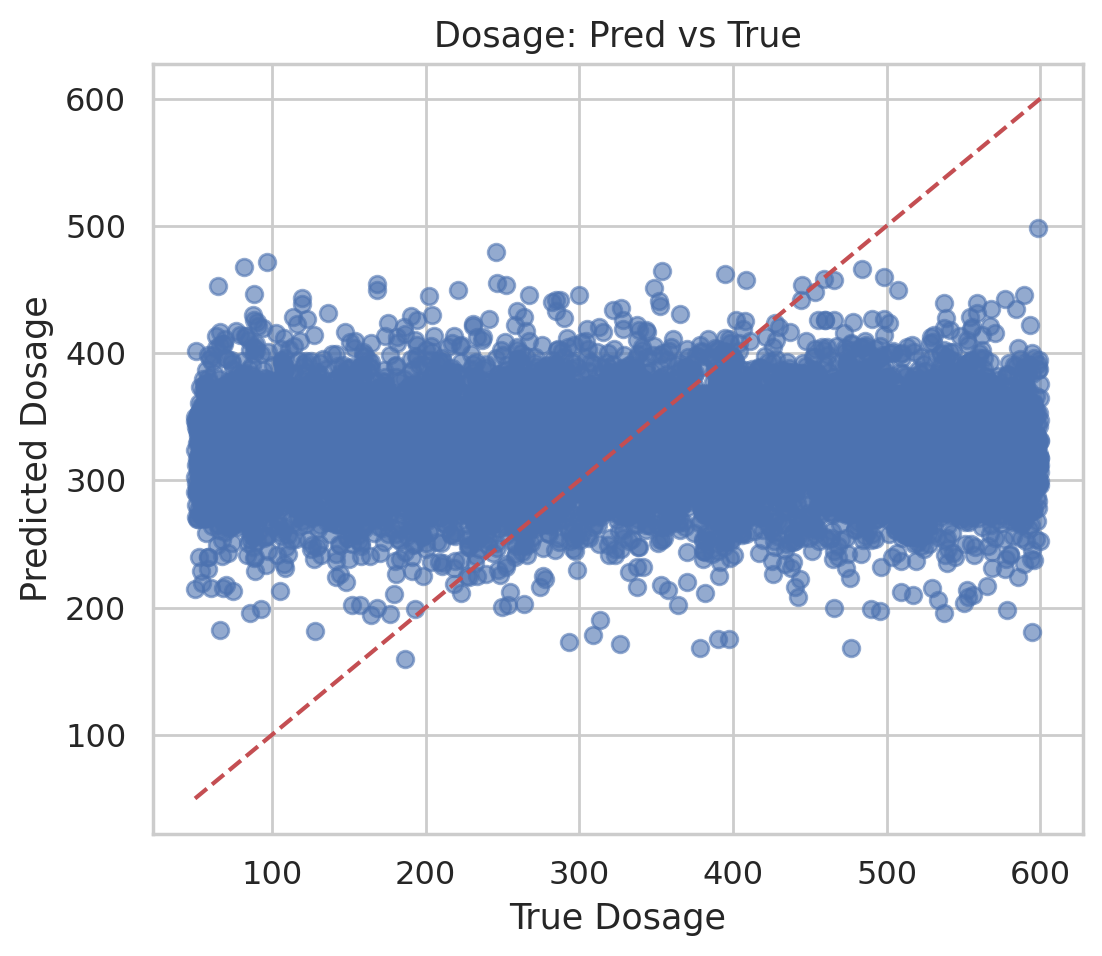

Saved: outputs/dosage_pred_vs_true.png


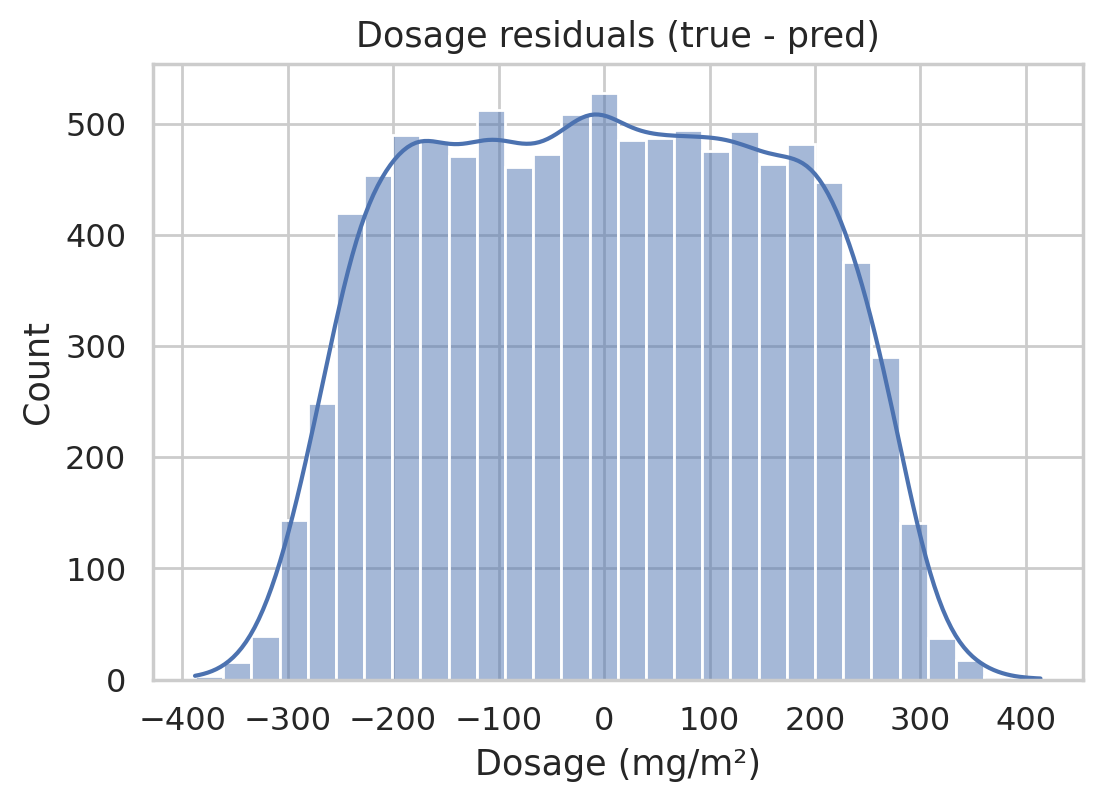

Saved: outputs/dosage_residuals.png

Cycles regressor: Train R2=0.334, Test R2=-0.059, Test MAE=1.749


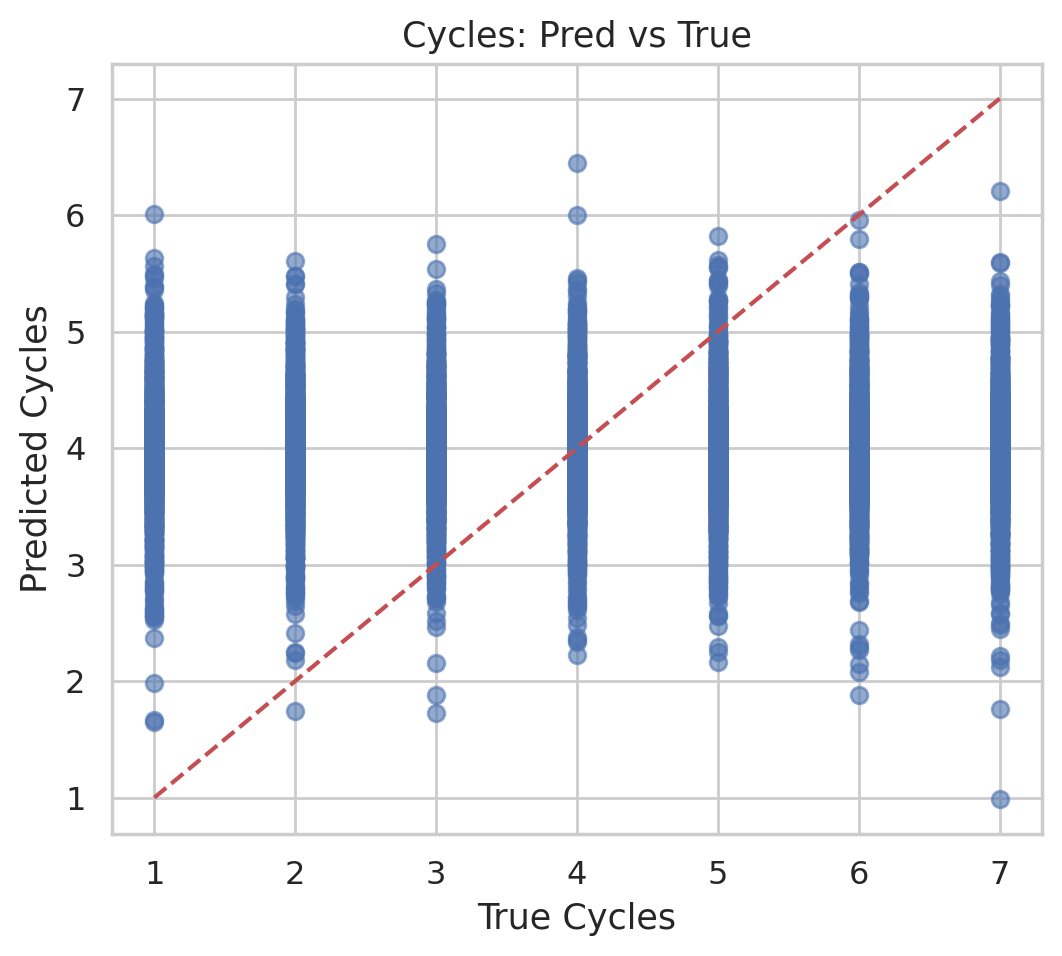

Saved: outputs/cycles_pred_vs_true.png


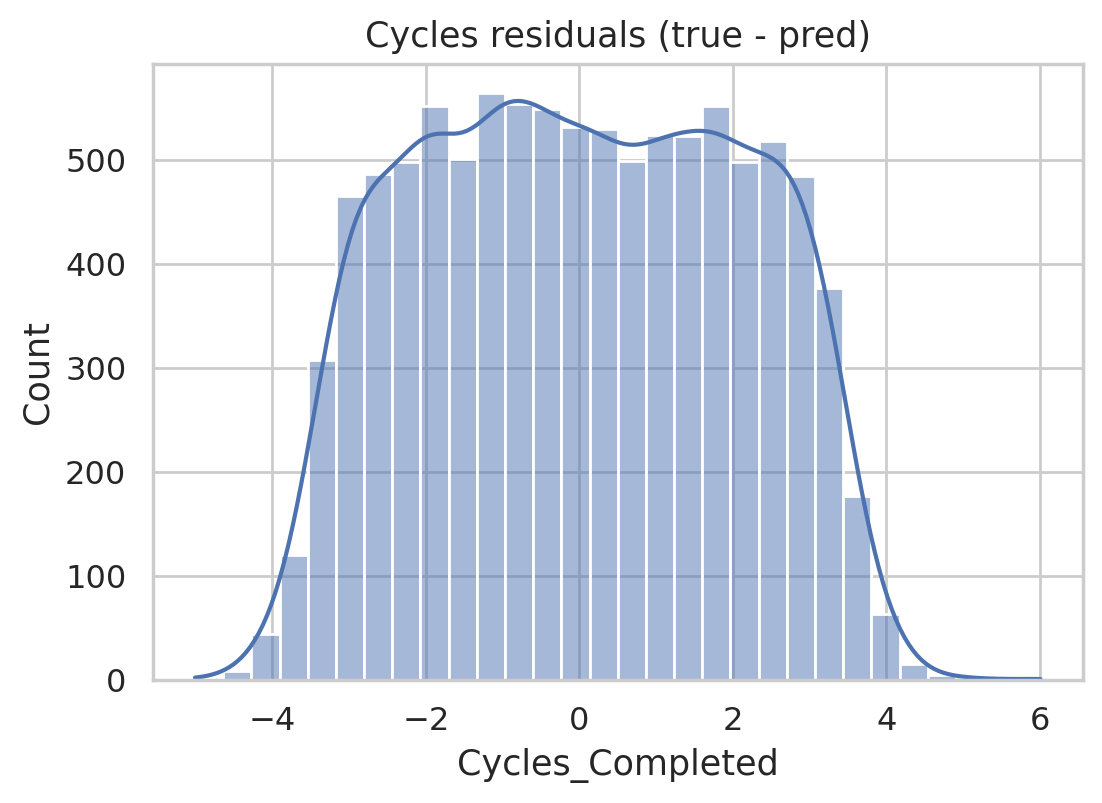

Saved: outputs/cycles_residuals.png

Survival regressor: Train R2=0.389, Test R2=-0.058, Test MAE=29.091


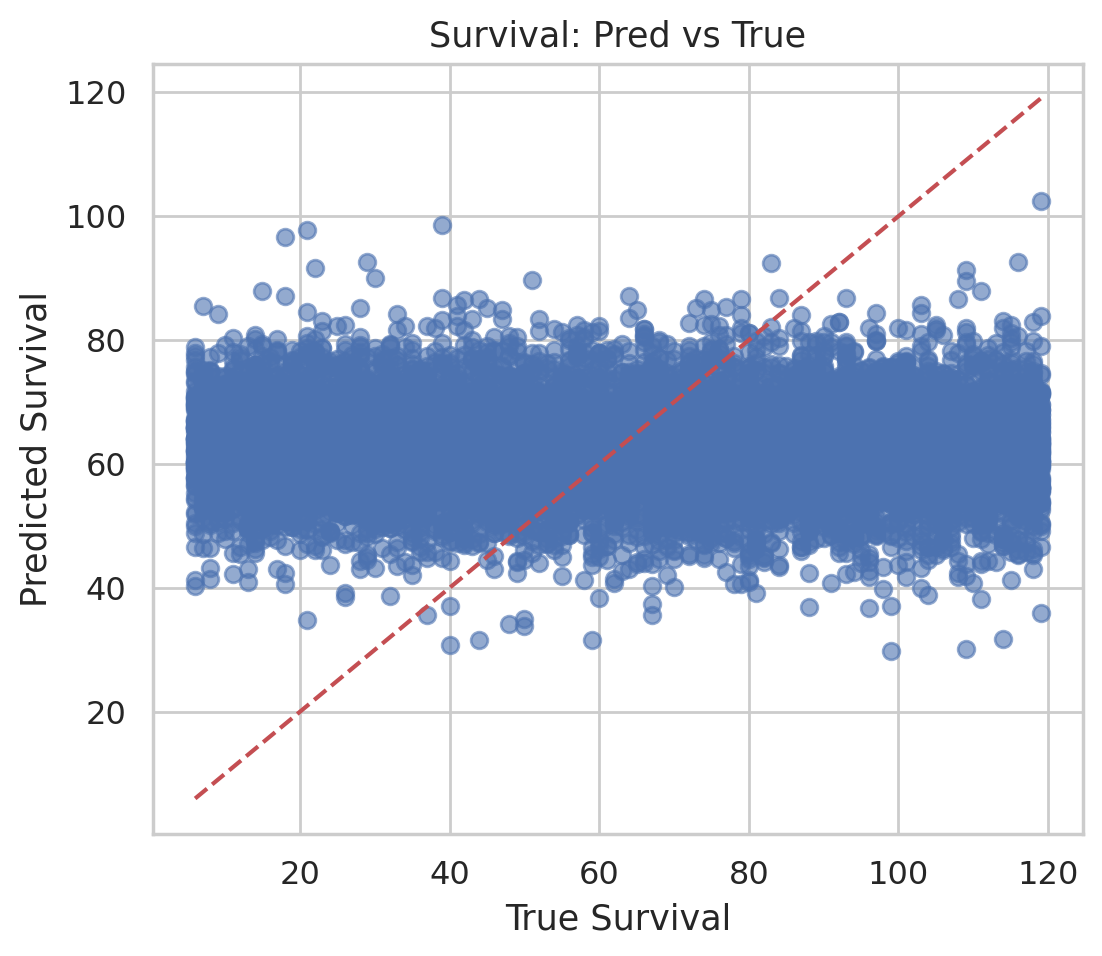

Saved: outputs/survival_pred_vs_true.png


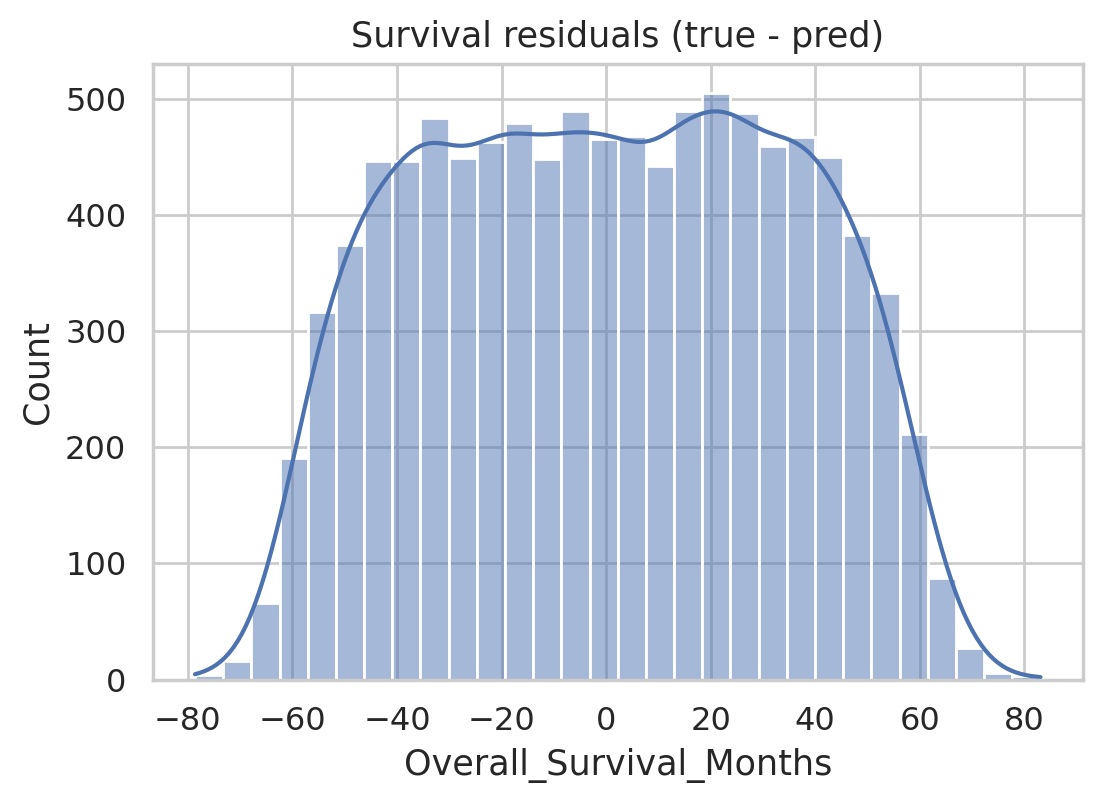

Saved: outputs/survival_residuals.png


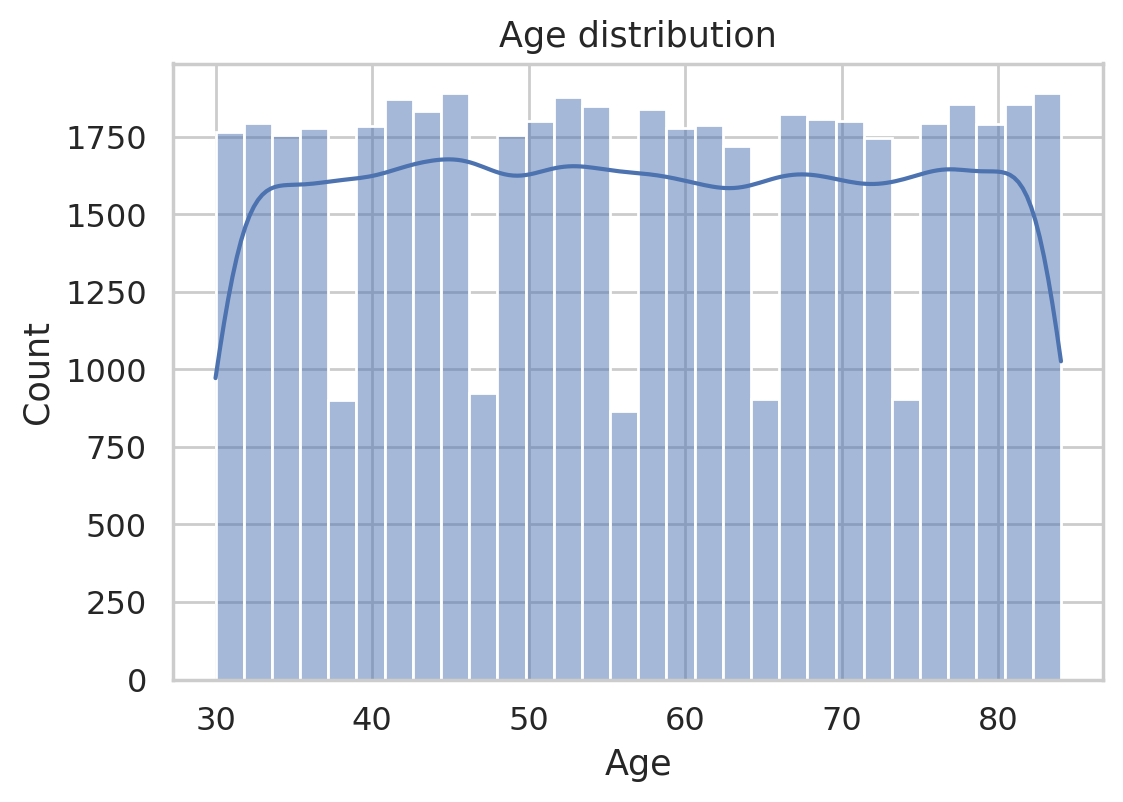

Saved: outputs/age_distribution.png


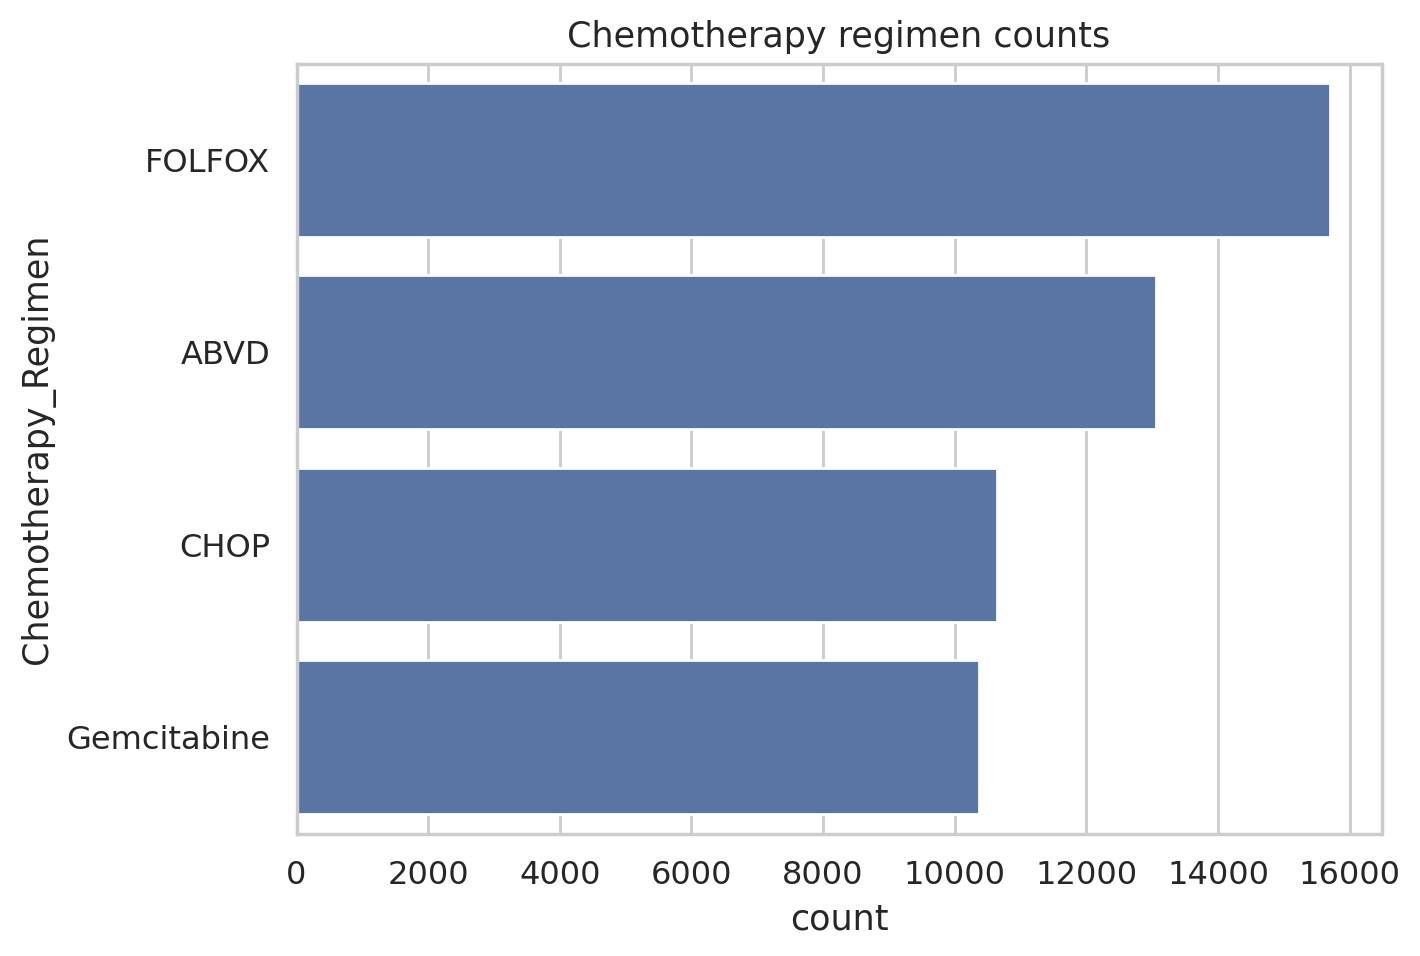

Saved: outputs/regimen_counts.png


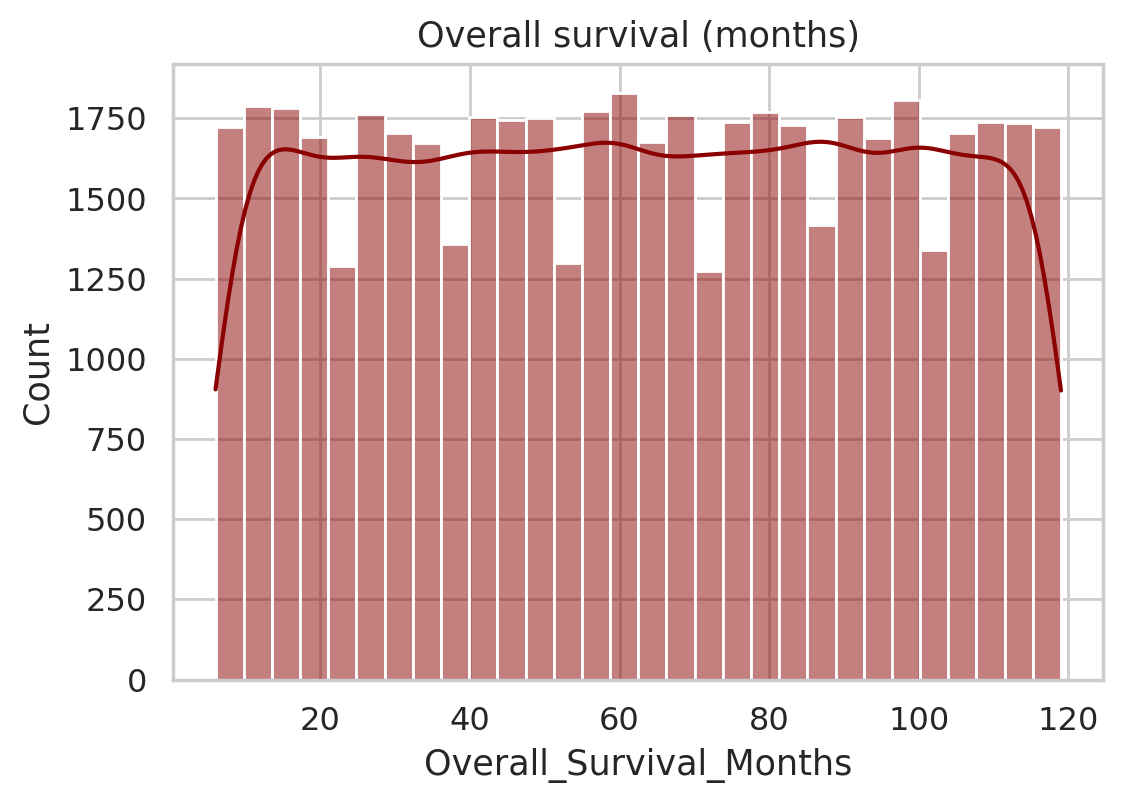

Saved: outputs/survival_distribution.png


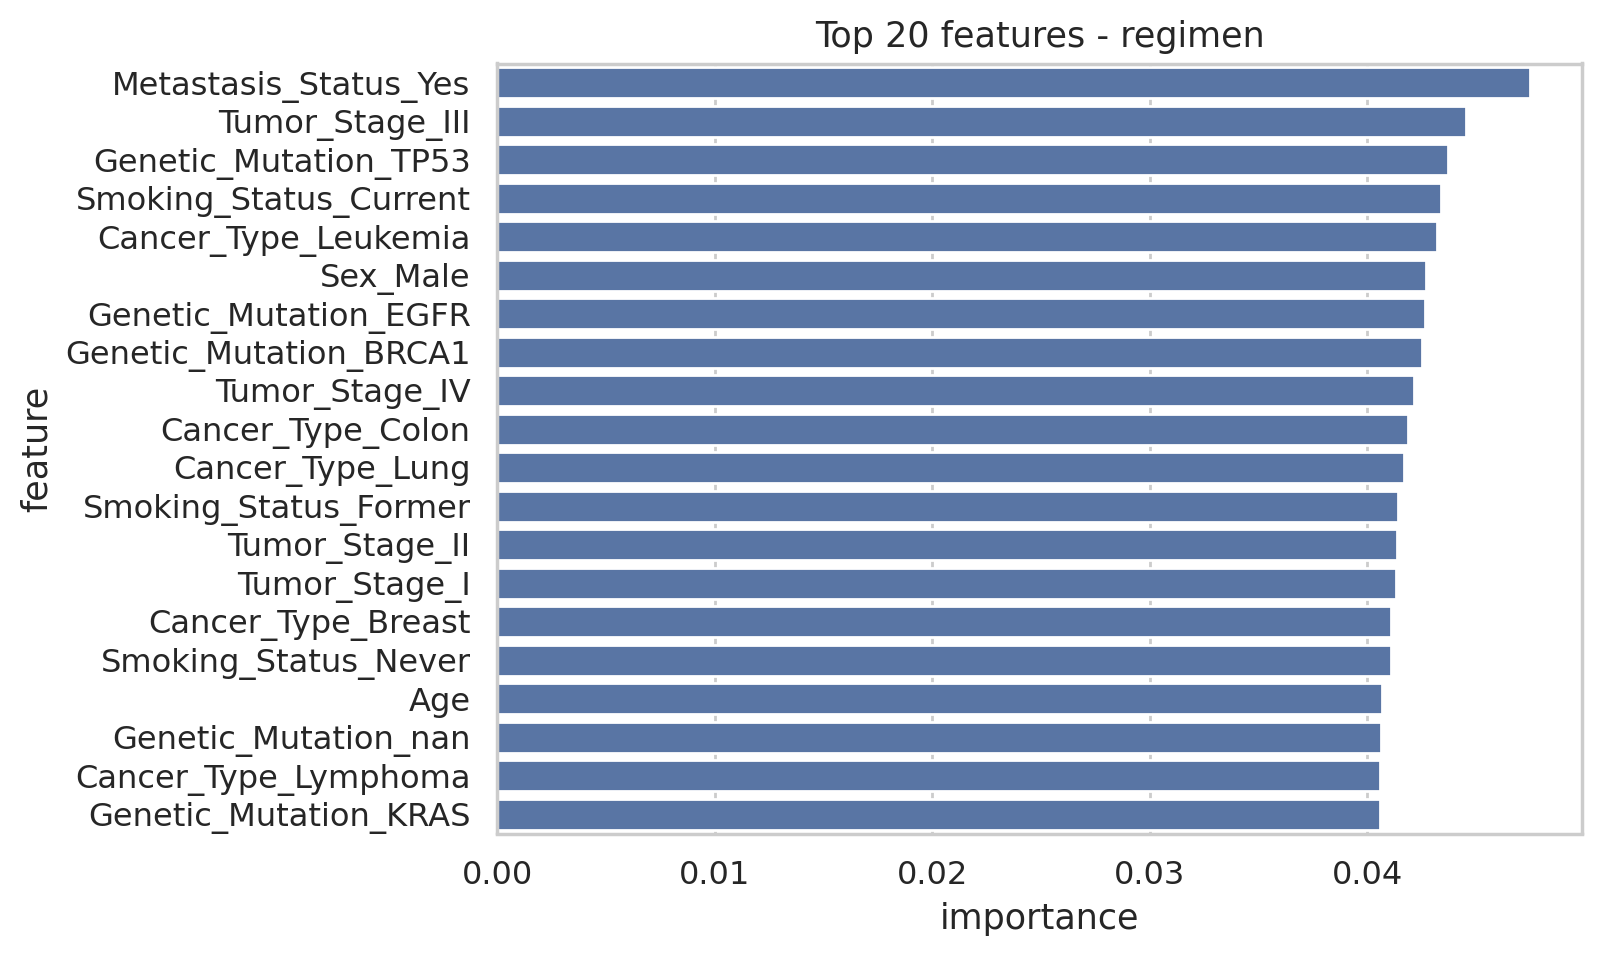

Saved: outputs/feature_importance_regimen.png


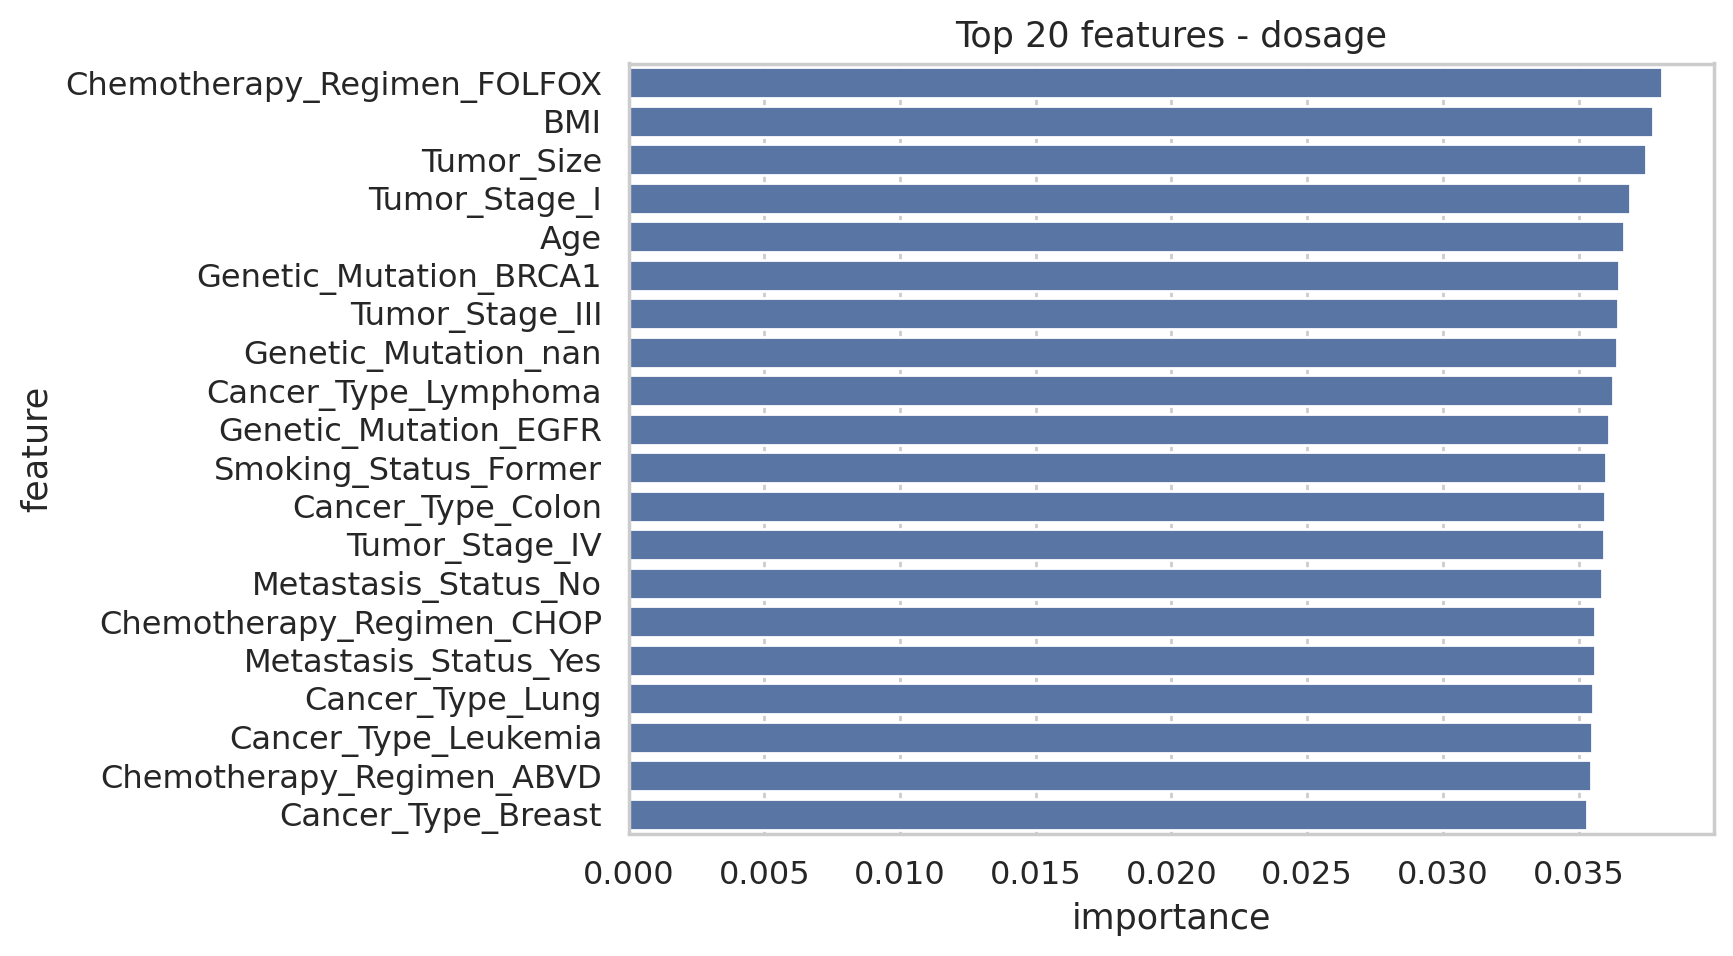

Saved: outputs/feature_importance_dosage.png


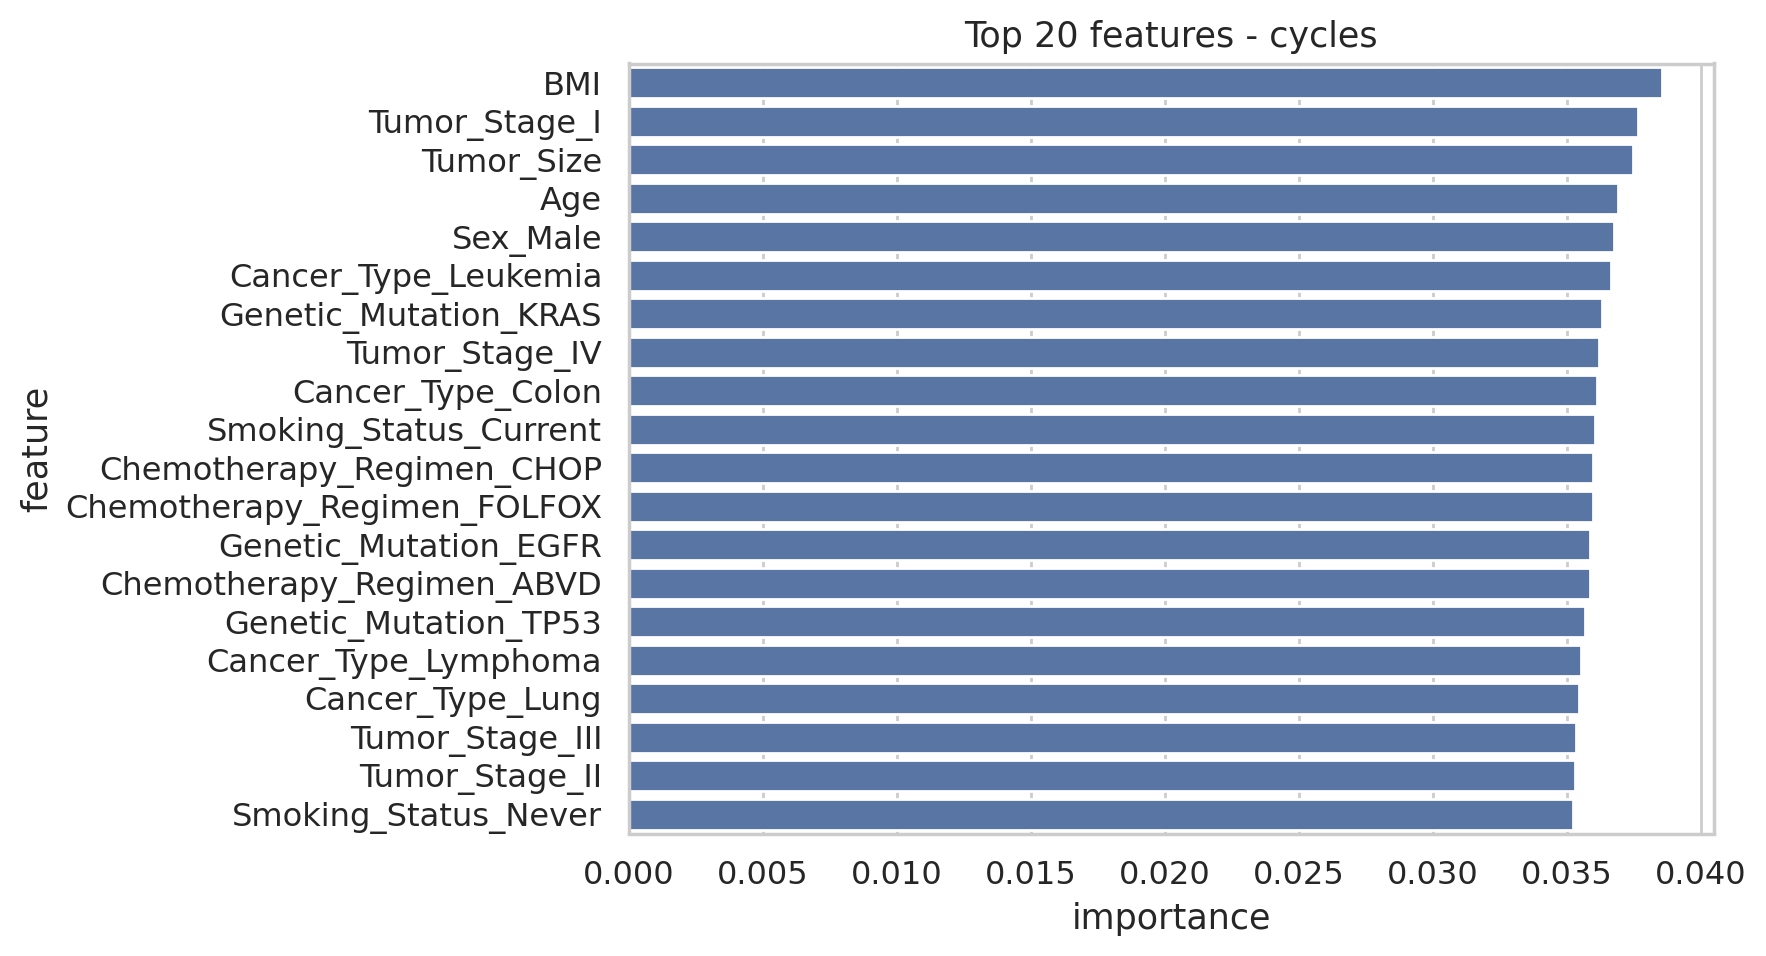

Saved: outputs/feature_importance_cycles.png


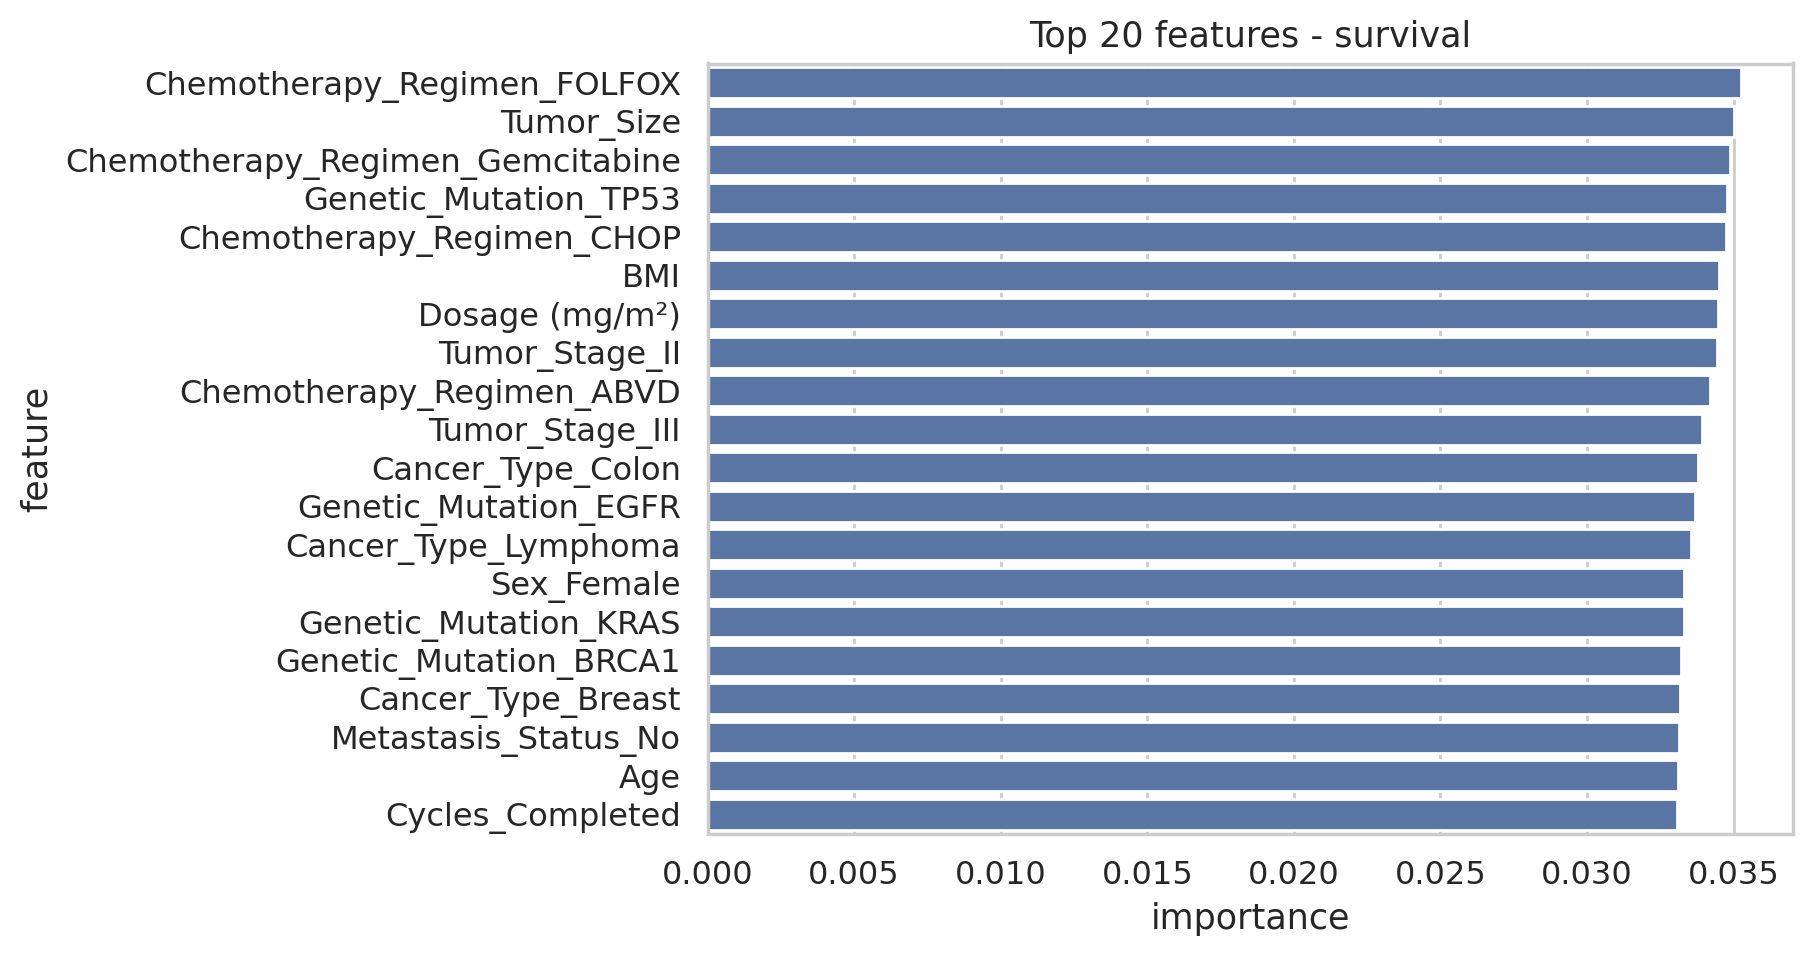

Saved: outputs/feature_importance_survival.png

Top recommended regimens for sample patient:
1. {'Regimen': 'Gemcitabine', 'Predicted_Dosage': 364.55, 'Predicted_Cycles': 4, 'Predicted_Survival_Months': 59.63}
2. {'Regimen': 'ABVD', 'Predicted_Dosage': 335.25, 'Predicted_Cycles': 4, 'Predicted_Survival_Months': 58.79}
3. {'Regimen': 'CHOP', 'Predicted_Dosage': 369.11, 'Predicted_Cycles': 4, 'Predicted_Survival_Months': 53.43}
4. {'Regimen': 'FOLFOX', 'Predicted_Dosage': 351.7, 'Predicted_Cycles': 4, 'Predicted_Survival_Months': 53.13}


In [245]:
# Cell 8: main runner - load, train, evaluate, visualize, save
if __name__ == "__main__":
    # 1) Load data
    df, _ = load_and_preprocess_data()
    if df is None:
        raise SystemExit("Dataset not found. Place the CSV in the working directory or update candidate_paths in load_and_preprocess_data().")

    # 2) Train models (or load if you prefer)
    print("\n--- Training models (this may take some minutes) ---")
    models = train_models(df, random_state=42, verbose=True)

    # 3) Save trained models
    save_models(models)

    # 4) Evaluate + produce figures (train/test metrics and plots saved to outputs/)
    evaluate_models(models)

    # 5) Dataset-level visualizations for paper
    visualize_dataset(df, show=True)

    # 6) Feature importance plots for each model (top 20)
    plot_feature_importance = globals().get('plot_feature_importances')
    if plot_feature_importance:
        try:
            plot_feature_importances(models['regimen_model'], model_label="regimen", topk=20, show=True)
            plot_feature_importances(models['dosage_model'], model_label="dosage", topk=20, show=True)
            plot_feature_importances(models['cycles_model'], model_label="cycles", topk=20, show=True)
            plot_feature_importances(models['survival_model'], model_label="survival", topk=20, show=True)
        except Exception as e:
            print("Feature importance plotting failed:", e)

    # 7) Example patient ranking
    sample_patient = {
        'Age': 55,
        'Sex': 'Female',
        'BMI': 28.5,
        'Smoking_Status': 'Former',
        'Cancer_Type': 'Breast',
        'Genetic_Mutation': 'BRCA1',
        'Tumor_Stage': 'II',
        'Tumor_Size': 4.2,
        'Metastasis_Status': 'No'
    }
    ranked = predict_and_rank_regimens(sample_patient, models, top_n=5)
    print("\nTop recommended regimens for sample patient:")
    for i, r in enumerate(ranked, 1):
        print(f"{i}. {r}")
